In [ ]:
!nvidia-smi

Sat Jan 17 07:49:51 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
%%capture
# Install required packages
# !pip install -U accelerate
# !pip install -U huggingface_hub  pillow requests
# !pip install transformers -U
!pip install transformers>=4.57.0
!pip install qwen-vl-utils>=0.0.14
# !pip install torch==2.8.0

print("✅ Installation complete!")

In [ ]:
!pip install qwen-vl-utils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 23.3 MB/s eta 0:00:00


In [ ]:
import torch
import numpy as np
from PIL import Image
import requests
from io import BytesIO
from typing import List, Dict, Any, Optional, Union
import torch.nn.functional as f
from transformers import Qwen3VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
import warnings

warnings.filterwarnings("ignore")

print(f"PyTorch version: {torch.__version__}")
print(f"Cuda available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:2f}GB")


PyTorch version: 2.9.0+cu126
Cuda available: True
Device name: Tesla T4
GPU Memory: 15.828320GB


## Qwen3-VL Embedder Implementation
- Wrapper class handling:
    - [x] Text only inputs
    - [x] Image-only inputs
    - [x] Mixed text+images inputs

In [6]:
import torch
import torch.nn.functional as F
import unicodedata
import numpy as np
import logging

from PIL import Image
from dataclasses import dataclass
from typing import Optional, List, Union, Dict, Any
from transformers.models.qwen3_vl.modeling_qwen3_vl import Qwen3VLPreTrainedModel, Qwen3VLModel, Qwen3VLConfig
from transformers.models.qwen3_vl.processing_qwen3_vl import Qwen3VLProcessor
from transformers.modeling_outputs import ModelOutput
from transformers.processing_utils import Unpack
from transformers.utils import TransformersKwargs
from transformers.cache_utils import Cache
from transformers.utils.generic import check_model_inputs
from qwen_vl_utils.vision_process import process_vision_info

logger = logging.getLogger(__name__)

# Constants for configuration
MAX_LENGTH = 8192
IMAGE_BASE_FACTOR = 16
IMAGE_FACTOR = IMAGE_BASE_FACTOR * 2
MIN_PIXELS = 4 * IMAGE_FACTOR * IMAGE_FACTOR
MAX_PIXELS = 1800 * IMAGE_FACTOR * IMAGE_FACTOR
FPS = 1
MAX_FRAMES = 64
FRAME_MAX_PIXELS = 768 * IMAGE_FACTOR * IMAGE_FACTOR
MAX_TOTAL_PIXELS = 10 * FRAME_MAX_PIXELS
PAD_TOKEN = "<|endoftext|>"

# Define output structure for embeddings
@dataclass
class Qwen3VLForEmbeddingOutput(ModelOutput):
    last_hidden_state: Optional[torch.FloatTensor] = None
    attention_mask: Optional[torch.Tensor] = None

# Define model class to compute embeddings
class Qwen3VLForEmbedding(Qwen3VLPreTrainedModel):
    _checkpoint_conversion_mapping = {}
    accepts_loss_kwargs = False
    config: Qwen3VLConfig

    def __init__(self, config):
        super().__init__(config)
        self.model = Qwen3VLModel(config)
        self.post_init()

    def get_input_embeddings(self):
        return self.model.get_input_embeddings()

    def set_input_embeddings(self, value):
        self.model.set_input_embeddings(value)

    def set_decoder(self, decoder):
        self.model.set_decoder(decoder)

    def get_decoder(self):
        return self.model.get_decoder()

    # Extract video features from model
    def get_video_features(self, pixel_values_videos: torch.FloatTensor,
                           video_grid_thw: Optional[torch.LongTensor] = None):
        return self.model.get_video_features(pixel_values_videos, video_grid_thw)

    # Extract image features from model
    def get_image_features(self, pixel_values: torch.FloatTensor,
                           image_grid_thw: Optional[torch.LongTensor] = None):
        return self.model.get_image_features(pixel_values, image_grid_thw)

    # Make modules accessible through properties
    @property
    def language_model(self):
        return self.model.language_model

    @property
    def visual(self):
        return self.model.visual

    # Forward pass through model with input parameters
    # @check_model_inputs
    def forward(self,
                input_ids: torch.LongTensor = None,
                attention_mask: Optional[torch.Tensor] = None,
                position_ids: Optional[torch.LongTensor] = None,
                past_key_values: Optional[Cache] = None,
                inputs_embeds: Optional[torch.FloatTensor] = None,
                pixel_values: Optional[torch.Tensor] = None,
                pixel_values_videos: Optional[torch.FloatTensor] = None,
                image_grid_thw: Optional[torch.LongTensor] = None,
                video_grid_thw: Optional[torch.LongTensor] = None,
                cache_position: Optional[torch.LongTensor] = None,
                logits_to_keep: Union[int, torch.Tensor] = 0,
                **kwargs: Unpack[TransformersKwargs],
    ) -> Union[tuple, Qwen3VLForEmbeddingOutput]:
        # Pass inputs through the model
        outputs = self.model(
            input_ids=input_ids,
            pixel_values=pixel_values,
            pixel_values_videos=pixel_values_videos,
            image_grid_thw=image_grid_thw,
            video_grid_thw=video_grid_thw,
            position_ids=position_ids,
            attention_mask=attention_mask,
            past_key_values=past_key_values,
            inputs_embeds=inputs_embeds,
            cache_position=cache_position,
            **kwargs,
        )
        # Return the model output
        return Qwen3VLForEmbeddingOutput(
            last_hidden_state=outputs.last_hidden_state,
            attention_mask=attention_mask,
        )

def sample_frames(frames: List[Union[str, Image.Image]], num_segments: int, max_segments: int) -> List[str]:
    duration = len(frames)
    frame_id_array = np.linspace(0, duration - 1, num_segments, dtype=int)
    frame_id_list = frame_id_array.tolist()
    last_frame_id = frame_id_list[-1]

    # Create a list of sampled frames
    sampled_frames = []
    for frame_idx in frame_id_list:
        try:
            sampled_frames.append(frames[frame_idx])
        except:
            break
    # Ensure the sampled list meets the required segment count
    while len(sampled_frames) < num_segments:
        sampled_frames.append(frames[last_frame_id])
    return sampled_frames[:max_segments]

# Define embedder class for processing inputs and generating embeddings
class Qwen3VLEmbedder():
    def __init__(
        self,
        model_name_or_path: str,
        max_length: int = MAX_LENGTH,
        min_pixels: int = MIN_PIXELS,
        max_pixels: int = MAX_PIXELS,
        total_pixels: int = MAX_TOTAL_PIXELS,
        fps: float = FPS,
        num_frames: int = MAX_FRAMES,
        max_frames: int = MAX_FRAMES,
        default_instruction: str = "Represent the user's input.",
        **kwargs
    ):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.max_length = max_length
        self.min_pixels = min_pixels
        self.max_pixels = max_pixels
        self.total_pixels = total_pixels
        self.fps = fps
        self.num_frames = num_frames
        self.max_frames = max_frames

        self.default_instruction = default_instruction

        self.model = Qwen3VLForEmbedding.from_pretrained(
            model_name_or_path, trust_remote_code=True, **kwargs
        ).to(device)
        self.processor = Qwen3VLProcessor.from_pretrained(
            model_name_or_path, padding_side='right'
        )
        self.model.eval()

    @torch.no_grad()
    def forward(self, inputs: Dict[str, Any]) -> Dict[str, torch.Tensor]:
        outputs = self.model(**inputs)
        return {
            'last_hidden_state': outputs.last_hidden_state,
            'attention_mask': inputs.get('attention_mask')
        }

    # Truncate token sequence to a specified max length
    def _truncate_tokens(self, token_ids: List[int], max_length: int) -> List[int]:
        if len(token_ids) <= max_length:
            return token_ids

        special_token_ids = set(self.processor.tokenizer.all_special_ids)
        num_special = sum(1 for token_idx in token_ids if token_idx in special_token_ids)
        num_non_special_to_keep = max_length - num_special

        final_token_ids = []
        non_special_kept_count = 0
        # Ensure retention of special tokens while truncating the rest
        for token_idx in token_ids:
            if token_idx in special_token_ids:
                final_token_ids.append(token_idx)
            elif non_special_kept_count < num_non_special_to_keep:
                final_token_ids.append(token_idx)
                non_special_kept_count += 1
        return final_token_ids

    # Format input based on provided text, image, video, and instruction
    def format_model_input(
        self, text: Optional[str] = None,
        image: Optional[Union[str, Image.Image]] = None,
        video: Optional[Union[str, List[Union[str, Image.Image]]]] = None,
        instruction: Optional[str] = None,
        fps: Optional[float] = None,
        max_frames: Optional[int] = None
    ) -> List[Dict]:

        # Ensure instruction ends with punctuation
        if instruction:
            instruction = instruction.strip()
            if instruction and not unicodedata.category(instruction[-1]).startswith('P'):
                instruction = instruction + '.'

        # Initialize conversation with system prompts
        content = []
        conversation = [
            {"role": "system", "content": [{"type": "text", "text": instruction or self.default_instruction}]},
            {"role": "user", "content": content}
        ]

        # Add text, image, or video content to conversation
        if not text and not image and not video:
            content.append({'type': 'text', 'text': "NULL"})
            return conversation

        if video:
            video_content = None
            video_kwargs = { 'total_pixels': self.total_pixels }
            if isinstance(video, list):
                video_content = video
                if self.num_frames is not None or self.max_frames is not None:
                    video_content = sample_frames(video_content, self.num_frames, self.max_frames)
                video_content = [
                    ('file://' + ele if isinstance(ele, str) else ele)
                    for ele in video_content
                ]
            elif isinstance(video, str):
                video_content = video if video.startswith(('http://', 'https://')) else 'file://' + video
                video_kwargs = {'fps': fps or self.fps, 'max_frames': max_frames or self.max_frames,}
            else:
                raise TypeError(f"Unrecognized video type: {type(video)}")

            # Add video input details to content
            if video_content:
                content.append({
                    'type': 'video', 'video': video_content,
                    **video_kwargs
                })

        if image:
            image_content = None
            if isinstance(image, Image.Image):
                image_content = image
            elif isinstance(image, str):
                image_content = image if image.startswith(('http', 'oss')) else 'file://' + image
            else:
                raise TypeError(f"Unrecognized image type: {type(image)}")

            # Add image input details to content
            if image_content:
                content.append({
                    'type': 'image', 'image': image_content,
                    "min_pixels": self.min_pixels,
                    "max_pixels": self.max_pixels
                })

        if text:
            content.append({'type': 'text', 'text': text})

        return conversation

        # Encode inputs into embeddings (CLIP-style API)
    def encode(
        self,
        inputs: List[Dict[str, Any]],
        normalize: bool = True
    ) -> torch.Tensor:
        """
        Encode text / image / video inputs into embeddings.
        """
        return self.process(inputs, normalize=normalize)

    # Compute cosine similarity between two embedding matrices
    @staticmethod
    def similarity(
        a: torch.Tensor,
        b: torch.Tensor
    ) -> np.ndarray:
        """
        Compute cosine similarity matrix between a and b.
        a: [N, D]
        b: [M, D]
        """
        # Ensure on CPU for numpy
        a = a.detach().cpu()
        b = b.detach().cpu()
        return (a @ b.T).numpy()

    # Preprocess input conversations for model consumption
    def _preprocess_inputs(self, conversations: List[List[Dict]]) -> Dict[str, torch.Tensor]:
        text = self.processor.apply_chat_template(
            conversations, add_generation_prompt=True, tokenize=False
        )

        try:
            images, video_inputs, video_kwargs = process_vision_info(
                conversations, image_patch_size=16,
                return_video_metadata=True, return_video_kwargs=True
            )
        except Exception as e:
            logger.error(f"Error in processing vision info: {e}")
            images = None
            video_inputs = None
            video_kwargs = {'do_sample_frames': False}
            text = self.processor.apply_chat_template(
                [{'role': 'user', 'content': [{'type': 'text', 'text': 'NULL'}]}],
                add_generation_prompt=True, tokenize=False
            )

        if video_inputs is not None:
            videos, video_metadata = zip(*video_inputs)
            videos = list(videos)
            video_metadata = list(video_metadata)
        else:
            videos, video_metadata = None, None

        inputs = self.processor(
            text=text, images=images, videos=videos, video_metadata=video_metadata, truncation=True,
            max_length=self.max_length, padding=True, do_resize=False, return_tensors='pt',
            **video_kwargs
        )
        return inputs

    # Pool the last hidden state by attention mask for embeddings
    @staticmethod
    def _pooling_last(hidden_state: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        flipped_tensor = attention_mask.flip(dims=[1])
        last_one_positions = flipped_tensor.argmax(dim=1)
        col = attention_mask.shape[1] - last_one_positions - 1
        row = torch.arange(hidden_state.shape[0], device=hidden_state.device)
        return hidden_state[row, col]

    # Process inputs to generate normalized embeddings
    def process(self, inputs: List[Dict[str, Any]], normalize: bool = True) -> tuple:
        conversations = [self.format_model_input(
            text=ele.get('text'),
            image=ele.get('image'),
            video=ele.get('video'),
            instruction=ele.get('instruction'),
            fps=ele.get('fps'),
            max_frames=ele.get('max_frames')
        ) for ele in inputs]

        processed_inputs = self._preprocess_inputs(conversations)
        processed_inputs = {k: v.to(self.model.device) for k, v in processed_inputs.items()}

        outputs = self.forward(processed_inputs)
        embeddings = self._pooling_last(outputs['last_hidden_state'], outputs['attention_mask'])

        # Normalize the embeddings if specified
        if normalize:
            embeddings = F.normalize(embeddings, p=2, dim=-1)

        return embeddings

## Clean the GUP

In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()


In [10]:
# =============================================================================
# Example usage
# =============================================================================
# Example 1: Load model automatically
print("=" * 60)
print("Example 1: Auto-load model")
print("=" * 60)

embedder = Qwen3VLEmbedder(
    model_name_or_path="Qwen/Qwen3-VL-Embedding-2B",
    dtype=torch.float16,          # NOT bf16
    device_map="auto",            # CRITICAL
    low_cpu_mem_usage=True
)


# Test inputs
inputs = [
    {"text": "A woman playing with her dog on a beach at sunset."},
    {"text": "City skyline at night with bright lights."},
]

embeddings = embedder.process(inputs)
print(f"Embeddings shape: {embeddings.shape}")
print(f"Similarity: {embeddings[0] @ embeddings[1]:.4f}")

# Example 2: Use pre-loaded model
# print("\n" + "=" * 60)
# print("Example 2: Pre-loaded model")
# print("=" * 60)

# Simulate pre-loaded model
# model = embedder.model
# processor = embedder.processor

# embedder2 = Qwen3VLEmbedderV2(
#     model=model,
#     processor=processor
# )

# embeddings2 = embedder2.process(inputs)
# print(f"Embeddings shape: {embeddings2.shape}")
# print(f"Same results: {np.allclose(embeddings, embeddings2)}")

Example 1: Auto-load model


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Embeddings shape: torch.Size([2, 2048])
Similarity: 0.1721


In [ ]:
# # Initialize the embedder
# embedder = Qwen3VLEmbedder(
#     model_name_or_path="Qwen/Qwen3-VL-Embedding-2B",
#     torch_dtype=torch.bfloat16,
# )

# # Specify the model path
# model_name_or_path = "Qwen/Qwen3-VL-Embedding-2B"

# # Initialize the Qwen3VLEmbedder model
# embedder = Qwen3VLEmbedder(model_name_or_path=model_name_or_path)

# # We recommend enabling flash_attention_2 for better acceleration and memory saving,
# model = Qwen3VLEmbedder(model_name_or_path=model_name_or_path, torch_dtype=torch.float16)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 20.12 MiB is free. Process 171483 has 14.72 GiB memory in use. Of the allocated memory 14.53 GiB is allocated by PyTorch, and 96.81 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import numpy as np
import torch

In [ ]:
# Define a list of query texts
queries = [
    {"text": "A woman playing with her dog on a beach at sunset."},
    {"text": "Pet owner training dog outdoors near water."},
    {"text": "Woman surfing on waves during a sunny day."},
    {"text": "City skyline view from a high-rise building at night."}
]

# Define a list of document texts and images
documents = [
    {"text": "A woman shares a joyful moment with her golden retriever on a sun-drenched beach at sunset, as the dog offers its paw in a heartwarming display of companionship and trust."},
    {"image": "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg"},
    {"text": "A woman shares a joyful moment with her golden retriever on a sun-drenched beach at sunset, as the dog offers its paw in a heartwarming display of companionship and trust.", "image": "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg"}
]

In [ ]:
# Combininig queries and documents into single input list
inputs = queries + documents

embeddings = embedder.process(inputs)

similarity_scores = (embeddings[:4] @ embeddings[4:].T)
print(similarity_scores.tolist())


[[0.81591796875, 0.71630859375, 0.716796875], [0.51953125, 0.330322265625, 0.439697265625], [0.388671875, 0.283935546875, 0.3310546875], [0.1094970703125, 0.039276123046875, 0.0706787109375]]


In [ ]:
demo_images = {
    "beach_dog": "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg",
    "cat_laptop": "https://images.unsplash.com/photo-1526336024174-e58f5cdd8e13?w=400",
    "mountain": "https://images.unsplash.com/photo-1464822759023-fed622ff2c3b?w=400",
    "city_night": "https://images.unsplash.com/photo-1519681393784-d120267933ba?w=400",
    "food_pizza": "https://images.unsplash.com/photo-1565299624946-b28f40a0ae38?w=400",
}


In [ ]:
print("Generating Embeddings...")
image_inputs = [{"image": url} for url in demo_images.values()]
image_embeddings = embedder.process(image_inputs)
print(f"Generated {len(image_embeddings)} image embeddings of dimensions {image_embeddings.shape[1]}")

image_names = list(demo_images.keys())

Generating Embeddings...
Generated 5 image embeddings of dimensions 2048


In [ ]:
# Define text queries
queries = [
    "A woman playing with her dog on a beach at sunset",
    "A fluffy cat relaxing",
    "Snowy mountain peaks",
    "City skyline at night with lights",
    "Delicious Italian food"
]

# Create query embeddings
print("🔄 Generating query embeddings...")
query_inputs = [
    {"text": q, "instruction": "Retrieve images that match this description."}
    for q in queries
]
query_embeddings = embedder.encode(query_inputs)

# Compute similarities
similarities = embedder.similarity(query_embeddings, image_embeddings)

# Display results
print("\n" + "="*70)
print("🔍 TEXT → IMAGE RETRIEVAL RESULTS")
print("="*70)

for i, query in enumerate(queries):
    print(f"\n📝 Query: \"{query}\"")

    # Get ranked results
    ranked_indices = np.argsort(similarities[i])[::-1]

    print("   Top matches:")
    for rank, idx in enumerate(ranked_indices[:3]):
        score = similarities[i][idx]
        print(f"   {rank+1}. {image_names[idx]:15} (score: {score:.4f})")

🔄 Generating query embeddings...

🔍 TEXT → IMAGE RETRIEVAL RESULTS

📝 Query: "A woman playing with her dog on a beach at sunset"
   Top matches:
   1. beach_dog       (score: 0.7212)
   2. cat_laptop      (score: 0.2344)
   3. food_pizza      (score: 0.1129)

📝 Query: "A fluffy cat relaxing"
   Top matches:
   1. cat_laptop      (score: 0.4749)
   2. beach_dog       (score: 0.1437)
   3. food_pizza      (score: 0.1387)

📝 Query: "Snowy mountain peaks"
   Top matches:
   1. city_night      (score: 0.5967)
   2. mountain        (score: 0.5757)
   3. cat_laptop      (score: 0.1218)

📝 Query: "City skyline at night with lights"
   Top matches:
   1. city_night      (score: 0.3826)
   2. mountain        (score: 0.2705)
   3. food_pizza      (score: 0.1301)

📝 Query: "Delicious Italian food"
   Top matches:
   1. food_pizza      (score: 0.3457)
   2. city_night      (score: 0.2358)
   3. mountain        (score: 0.1752)


## Part 5: Mini Multimodal RAG system


In [11]:
class Qwen3VLReranker:
    def __init__(self, model: Qwen3VLEmbedder):
        self.model = model

    @torch.no_grad()
    def score(self, query: str, doc: dict) -> float:
        """
        Score relevance between query and a document using Qwen3-VL.
        """
        instruction = (
            "You are a multimodal relevance judge. "
            "Rate how relevant the document is to the query from 0 to 1. "
            "Only output a single number."
        )

        input_data = {
            "text": (
                f"Query: {query}\n"
                f"Document text: {doc['content'].get('text', 'None')}"
            ),
            "image": doc["content"].get("image"),
            "instruction": instruction
        }

        # Use the model in generation mode
        inputs = self.model.format_model_input(**input_data)
        processed = self.model._preprocess_inputs([inputs])
        processed = {k: v.to(self.model.model.device) for k, v in processed.items()}

        output = self.model.model.generate(
            **processed,
            max_new_tokens=5,
            do_sample=False
        )

        text = self.model.processor.batch_decode(
            output, skip_special_tokens=True
        )[0]

        # Extract float safely
        try:
            score = float(text.strip().split()[0])
        except:
            score = 0.0

        return max(0.0, min(score, 1.0))


reranker = Qwen3VLReranker(embedder)


In [12]:
from IPython.display import display
import requests
from io import BytesIO
from PIL import Image


class MultimodalRAG:
    """
    A simple multimodal RAG system using Qwen3-VL-Embedding.

    Supports:
    - Adding text documents
    - Adding images (with optional captions)
    - Adding mixed text+image documents
    - Semantic search with any modality
    """

    def __init__(self, embedder: Qwen3VLEmbedder):
        self.embedder = embedder
        self.documents = []  # List of document dicts
        self.embeddings = None  # numpy array of embeddings

    def add_text(self, text: str, metadata: dict = None):
        """Add a text document."""
        doc = {
            "type": "text",
            "content": {"text": text},
            "display": text[:100] + "..." if len(text) > 100 else text,
            "metadata": metadata or {}
        }
        self.documents.append(doc)
        return len(self.documents) - 1

    def add_image(self, image: Union[str, Image.Image], caption: str = None, metadata: dict = None):
        """Add an image with optional caption."""
        content = {"image": image}
        if caption:
            content["text"] = caption

        doc = {
            "type": "image" if not caption else "image+text",
            "content": content,
            "display": caption if caption else f"Image: {str(image)[:50]}...",
            "metadata": metadata or {},
            "image_source": image
        }
        self.documents.append(doc)
        return len(self.documents) - 1

    def build_index(self, batch_size: int = 4):
      """
      Build the embedding index for all documents with a progress bar.
      """
      if not self.documents:
          raise ValueError("No documents to index!")

      print(f"📊 Building index for {len(self.documents)} documents...")

      all_embeddings = []

      for i in tqdm(
          range(0, len(self.documents), batch_size),
          desc="🔄 Encoding documents",
      ):
          batch_docs = self.documents[i : i + batch_size]
          batch_inputs = [doc["content"] for doc in batch_docs]

          batch_embs = self.embedder.encode(batch_inputs)
          all_embeddings.append(batch_embs.cpu())

          # Optional: free GPU cache between batches
          torch.cuda.empty_cache()

      self.embeddings = torch.cat(all_embeddings, dim=0)
      print(f"✅ Index built! Shape: {self.embeddings.shape}")


    def search(
        self,
        query: Union[str, Dict],
        top_k: int = 5,
        instruction: str = "Find relevant documents for this query."
    ) -> List[Dict]:
        """
        Search for relevant documents.

        Args:
            query: Text string or dict with 'text' and/or 'image'
            top_k: Number of results to return
            instruction: Search instruction

        Returns:
            List of (document, score) tuples
        """
        if self.embeddings is None:
            raise ValueError("Index not built! Call build_index() first.")

        # Prepare query
        if isinstance(query, str):
            query_input = {"text": query, "instruction": instruction}
        else:
            query_input = {**query, "instruction": instruction}

        # Get query embedding
        query_embedding = self.embedder.encode([query_input])

        # Compute similarities
        similarities = self.embedder.similarity(query_embedding, self.embeddings)[0]

        # Get top-k results
        top_indices = np.argsort(similarities)[::-1][:top_k]

        results = []
        for idx in top_indices:
            results.append({
                "document": self.documents[idx],
                "score": float(similarities[idx]),
                "index": int(idx)
            })

        return results

    def display_results(self, results: List[Dict], show_images: bool = True):
        """Pretty print search results."""
        print("\n" + "="*60)
        print("🔍 SEARCH RESULTS")
        print("="*60)

        for i, result in enumerate(results):
            doc = result["document"]
            score = result["score"]

            print(f"\n{'─'*60}")
            print(f"📌 Result {i+1} | Score: {score:.4f} | Type: {doc['type']}")
            print(f"{'─'*60}")
            print(f"📝 {doc['display']}")

            if doc['metadata']:
                print(f"🏷️ Metadata: {doc['metadata']}")

            # Show image if applicable
            # Show image if applicable
            if show_images and 'image' in doc['type']:
                source = doc.get('image_source')

                try:
                    # Case 1: PIL Image (your current dataset)
                    if isinstance(source, Image.Image):
                        img = source.copy()
                        img.thumbnail((256, 256))
                        display(img)

                    # Case 2: Image URL
                    elif isinstance(source, str) and source.startswith("http"):
                        response = requests.get(source, timeout=10)
                        response.raise_for_status()
                        img = Image.open(BytesIO(response.content)).convert("RGB")
                        img.thumbnail((256, 256))
                        display(img)

                except Exception as e:
                    print("   [Could not display image]", e)
    def search_with_rerank(
        self,
        query: str,
        top_k: int = 3,
        candidate_k: int = 10):
    # Step 1: fast retrieval
      candidates = self.search(query, top_k=candidate_k)

      # Step 2: rerank
      scored = []
      for c in candidates:
          score = reranker.score(query, c["document"])
          scored.append({**c, "rerank_score": score})

      # Step 3: sort by rerank score
      scored.sort(key=lambda x: x["rerank_score"], reverse=True)

      return scored[:top_k]



In [ ]:
# Initialize RAG system
rag = MultimodalRAG(embedder)

# Add some text documents
rag.add_text(
    "Machine learning is a subset of artificial intelligence that enables systems to learn from data.",
    metadata={"topic": "AI", "source": "textbook"}
)
rag.add_text(
    "The golden retriever is one of the most popular dog breeds, known for their friendly nature.",
    metadata={"topic": "animals", "source": "encyclopedia"}
)
rag.add_text(
    "Pizza originated in Naples, Italy, and has become one of the world's most beloved foods.",
    metadata={"topic": "food", "source": "food blog"}
)
rag.add_text(
    "Mount Everest is the tallest mountain in the world, located in the Himalayas.",
    metadata={"topic": "geography", "source": "atlas"}
)

# Add images with captions
rag.add_image(
    demo_images["beach_dog"],
    caption="A woman enjoying time with her golden retriever on a beautiful beach at sunset",
    metadata={"topic": "pets", "location": "beach"}
)
rag.add_image(
    demo_images["mountain"],
    caption="Majestic snow-capped mountain peaks under a clear blue sky",
    metadata={"topic": "nature", "location": "mountains"}
)
rag.add_image(
    demo_images["food_pizza"],
    caption="Delicious homemade pizza with fresh toppings",
    metadata={"topic": "food", "cuisine": "Italian"}
)
rag.add_image(
    demo_images["city_night"],
    caption="City skyline illuminated at night with mountain backdrop",
    metadata={"topic": "urban", "time": "night"}
)

print(f"\n📚 Added {len(rag.documents)} documents to the RAG system")


📚 Added 8 documents to the RAG system


### Real-world usecases

In [ ]:
!pip install datasets

## Product-style dataset

In [ ]:
!wget https://github.com/myleott/mnist_png/raw/master/mnist_png.tar.gz
!tar -xzf mnist_png.tar.gz


--2026-01-17 11:09:26--  https://github.com/myleott/mnist_png/raw/master/mnist_png.tar.gz
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/myleott/mnist_png/master/mnist_png.tar.gz [following]
--2026-01-17 11:09:26--  https://raw.githubusercontent.com/myleott/mnist_png/master/mnist_png.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15683414 (15M) [application/octet-stream]
Saving to: ‘mnist_png.tar.gz’

mnist_png.tar.gz    100%[===================>]  14.96M  --.-KB/s    in 0.06s   

2026-01-17 11:09:27 (268 MB/s) - ‘mnist_png.tar.gz’ saved [15683414/15683414]



In [ ]:
!wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
!tar -xzf flower_photos.tgz


--2026-01-17 11:09:59--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.207, 172.217.218.207, 142.251.31.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M  39.4MB/s    in 6.3s    

2026-01-17 11:10:06 (34.7 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



In [ ]:
import os
from PIL import Image

rag = MultimodalRAG(embedder)

base_dir = "flower_photos"

for label in os.listdir(base_dir):
    class_dir = os.path.join(base_dir, label)
    if not os.path.isdir(class_dir):
        continue

    for fname in os.listdir(class_dir)[:20]:  # limit for Colab
        path = os.path.join(class_dir, fname)
        img = Image.open(path).convert("RGB")

        caption = f"A photo of {label.replace('_', ' ')}"
        rag.add_image(
            image=img,
            caption=caption,
            metadata={"category": label, "file": fname}
        )

rag.build_index()


📊 Building index for 100 documents...
✅ Index built! Shape: torch.Size([100, 2048])



🔎 Query: Yellow flowers

🔍 SEARCH RESULTS

────────────────────────────────────────────────────────────
📌 Result 1 | Score: 0.4890 | Type: image+text
────────────────────────────────────────────────────────────
📝 A photo of sunflowers
🏷️ Metadata: {'category': 'sunflowers', 'file': '7652532108_01ef94c476.jpg'}


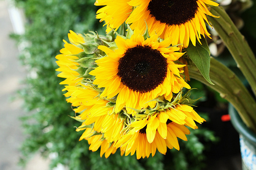


────────────────────────────────────────────────────────────
📌 Result 2 | Score: 0.4822 | Type: image+text
────────────────────────────────────────────────────────────
📝 A photo of roses
🏷️ Metadata: {'category': 'roses', 'file': '8667746487_781af9e615_n.jpg'}


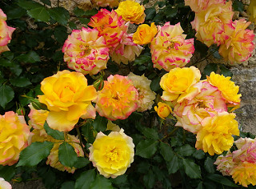


────────────────────────────────────────────────────────────
📌 Result 3 | Score: 0.4778 | Type: image+text
────────────────────────────────────────────────────────────
📝 A photo of sunflowers
🏷️ Metadata: {'category': 'sunflowers', 'file': '3514340206_efb8198a80_n.jpg'}


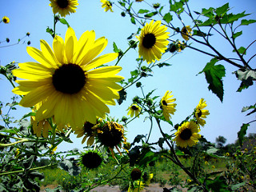


🔎 Query: A photo of roses

🔍 SEARCH RESULTS

────────────────────────────────────────────────────────────
📌 Result 1 | Score: 0.7490 | Type: image+text
────────────────────────────────────────────────────────────
📝 A photo of roses
🏷️ Metadata: {'category': 'roses', 'file': '15333843782_060cef3030.jpg'}


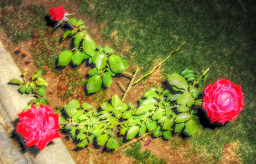


────────────────────────────────────────────────────────────
📌 Result 2 | Score: 0.7227 | Type: image+text
────────────────────────────────────────────────────────────
📝 A photo of roses
🏷️ Metadata: {'category': 'roses', 'file': '8241471746_5d81fdd3c0_n.jpg'}


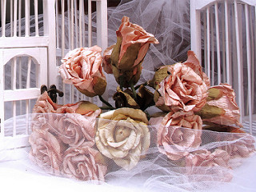


────────────────────────────────────────────────────────────
📌 Result 3 | Score: 0.7212 | Type: image+text
────────────────────────────────────────────────────────────
📝 A photo of roses
🏷️ Metadata: {'category': 'roses', 'file': '3278709893_ba4956a572_n.jpg'}


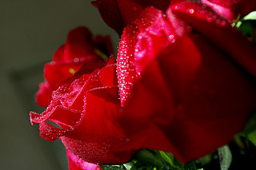


🔎 Query: Flowers in a garden

🔍 SEARCH RESULTS

────────────────────────────────────────────────────────────
📌 Result 1 | Score: 0.5249 | Type: image+text
────────────────────────────────────────────────────────────
📝 A photo of sunflowers
🏷️ Metadata: {'category': 'sunflowers', 'file': '4933230991_d50c0f7c66.jpg'}


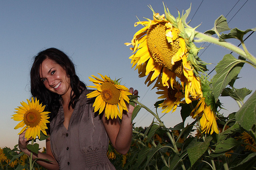


────────────────────────────────────────────────────────────
📌 Result 2 | Score: 0.5181 | Type: image+text
────────────────────────────────────────────────────────────
📝 A photo of tulips
🏷️ Metadata: {'category': 'tulips', 'file': '8711277462_b43df5454b_m.jpg'}


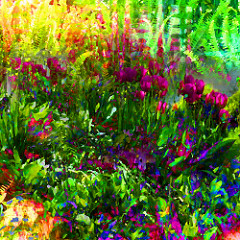


────────────────────────────────────────────────────────────
📌 Result 3 | Score: 0.5161 | Type: image+text
────────────────────────────────────────────────────────────
📝 A photo of sunflowers
🏷️ Metadata: {'category': 'sunflowers', 'file': '2980154410_bffd7a3452_n.jpg'}


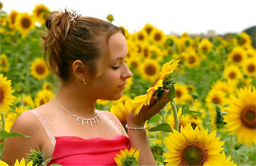


🔎 Query: Close-up of petals

🔍 SEARCH RESULTS

────────────────────────────────────────────────────────────
📌 Result 1 | Score: 0.4592 | Type: image+text
────────────────────────────────────────────────────────────
📝 A photo of roses
🏷️ Metadata: {'category': 'roses', 'file': '4505921907_21c8002fde.jpg'}


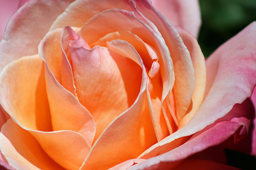


────────────────────────────────────────────────────────────
📌 Result 2 | Score: 0.4465 | Type: image+text
────────────────────────────────────────────────────────────
📝 A photo of roses
🏷️ Metadata: {'category': 'roses', 'file': '4921988677_e2eb0c9a24_m.jpg'}


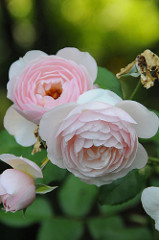


────────────────────────────────────────────────────────────
📌 Result 3 | Score: 0.4329 | Type: image+text
────────────────────────────────────────────────────────────
📝 A photo of roses
🏷️ Metadata: {'category': 'roses', 'file': '8775267816_726ddc6d92_n.jpg'}


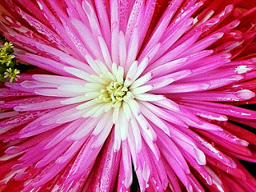

In [ ]:
queries = [
    "Yellow flowers",
    "A photo of roses",
    "Flowers in a garden",
    "Close-up of petals",
]

for q in queries:
    print(f"\n🔎 Query: {q}")
    results = rag.search(q, top_k=3)
    rag.display_results(results)


🔍 BEFORE (embedding only)

🔍 SEARCH RESULTS

────────────────────────────────────────────────────────────
📌 Result 1 | Score: 0.4890 | Type: image+text
────────────────────────────────────────────────────────────
📝 A photo of sunflowers
🏷️ Metadata: {'category': 'sunflowers', 'file': '7652532108_01ef94c476.jpg'}


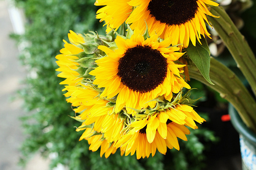


────────────────────────────────────────────────────────────
📌 Result 2 | Score: 0.4822 | Type: image+text
────────────────────────────────────────────────────────────
📝 A photo of roses
🏷️ Metadata: {'category': 'roses', 'file': '8667746487_781af9e615_n.jpg'}


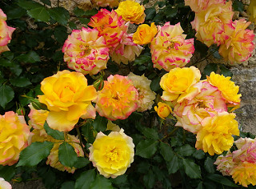


────────────────────────────────────────────────────────────
📌 Result 3 | Score: 0.4778 | Type: image+text
────────────────────────────────────────────────────────────
📝 A photo of sunflowers
🏷️ Metadata: {'category': 'sunflowers', 'file': '3514340206_efb8198a80_n.jpg'}


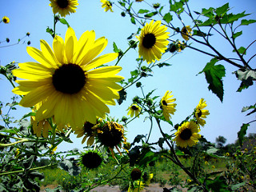


🔁 AFTER (with reranking)


AttributeError: 'MultimodalRAG' object has no attribute 'search_with_rerank'

In [ ]:
query = "Yellow flowers"

print("🔍 BEFORE (embedding only)")
rag.display_results(rag.search(query, top_k=3))

# print("\n🔁 AFTER (with reranking)")
# reranked = rag.search_with_rerank(query, top_k=3)
# rag.display_results(reranked)



In [13]:
from datasets import load_dataset

dataset = load_dataset("UniqueData/crowd-counting-dataset", split="train[:200]")


Resolving data files:   0%|          | 0/61 [00:00<?, ?it/s]

In [14]:
from tqdm import tqdm

rag = MultimodalRAG(embedder)
subset = dataset.select(range(10))

for idx, item in enumerate(tqdm(subset, desc="Ingesting images")):
  img = item["image"]        # PIL.Image
  label = item["label"]

  rag.add_image(
        image=img,
        caption="CCTV image of a public area",
        metadata={
            "crowd_label": int(label),
            "id": idx
        }
    )

rag.build_index()

Ingesting images: 100%|██████████| 10/10 [00:00<00:00, 47.94it/s]


📊 Building index for 10 documents...


🔄 Encoding documents: 100%|██████████| 3/3 [07:09<00:00, 143.09s/it]

✅ Index built! Shape: torch.Size([10, 2048])



🔍 SEARCH RESULTS

────────────────────────────────────────────────────────────
📌 Result 1 | Score: 0.2563 | Type: image+text
────────────────────────────────────────────────────────────
📝 CCTV image of a public area
🏷️ Metadata: {'crowd_label': 1, 'id': 7}


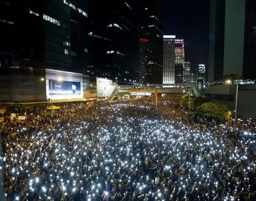


────────────────────────────────────────────────────────────
📌 Result 2 | Score: 0.2406 | Type: image+text
────────────────────────────────────────────────────────────
📝 CCTV image of a public area
🏷️ Metadata: {'crowd_label': 1, 'id': 6}


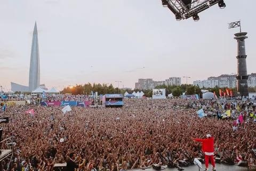


────────────────────────────────────────────────────────────
📌 Result 3 | Score: 0.1868 | Type: image+text
────────────────────────────────────────────────────────────
📝 CCTV image of a public area
🏷️ Metadata: {'crowd_label': 0, 'id': 2}


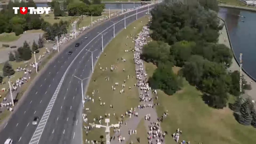


────────────────────────────────────────────────────────────
📌 Result 4 | Score: 0.1776 | Type: image+text
────────────────────────────────────────────────────────────
📝 CCTV image of a public area
🏷️ Metadata: {'crowd_label': 1, 'id': 4}


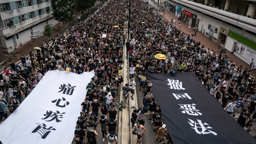


────────────────────────────────────────────────────────────
📌 Result 5 | Score: 0.1755 | Type: image+text
────────────────────────────────────────────────────────────
📝 CCTV image of a public area
🏷️ Metadata: {'crowd_label': 2, 'id': 9}


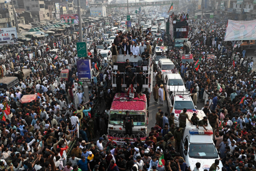


────────────────────────────────────────────────────────────
📌 Result 6 | Score: 0.1742 | Type: image+text
────────────────────────────────────────────────────────────
📝 CCTV image of a public area
🏷️ Metadata: {'crowd_label': 1, 'id': 5}


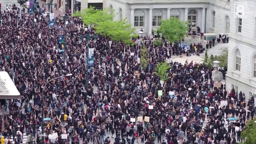


────────────────────────────────────────────────────────────
📌 Result 7 | Score: 0.1691 | Type: image+text
────────────────────────────────────────────────────────────
📝 CCTV image of a public area
🏷️ Metadata: {'crowd_label': 0, 'id': 0}


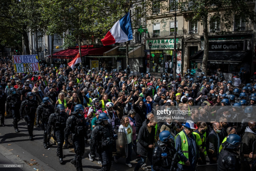


────────────────────────────────────────────────────────────
📌 Result 8 | Score: 0.1445 | Type: image+text
────────────────────────────────────────────────────────────
📝 CCTV image of a public area
🏷️ Metadata: {'crowd_label': 2, 'id': 8}


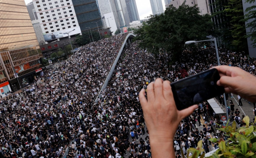


────────────────────────────────────────────────────────────
📌 Result 9 | Score: 0.1392 | Type: image+text
────────────────────────────────────────────────────────────
📝 CCTV image of a public area
🏷️ Metadata: {'crowd_label': 0, 'id': 3}


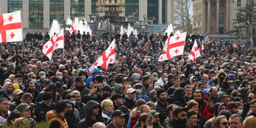


────────────────────────────────────────────────────────────
📌 Result 10 | Score: 0.1193 | Type: image+text
────────────────────────────────────────────────────────────
📝 CCTV image of a public area
🏷️ Metadata: {'crowd_label': 0, 'id': 1}


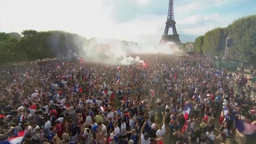

In [19]:
results = rag.search("Night ", top_k=510)
rag.display_results(results)
